In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

from notebook_client.notebook_client import NotebookClient

In [2]:
nc = NotebookClient()
nc.initialize_producers_manager_connection()
nc.initialize_sampler_manager_connection()

In [3]:
producer_pid = nc.start_streaming('input_topic', { 'locations': '-74,40,-73,41' })


In [7]:
reservoir_size = 5
limit = 20
nc.start_sampling('input_topic', 'output_topic', reservoir_size, limit)

In [6]:
nc.streaming_status(producer_pid)

'running'

In [14]:
nc.sampling_status()

'running'

In [85]:
nc.stop_streaming(producer_pid)

'stopped'

In [15]:
from kafka import KafkaConsumer

consumer = KafkaConsumer('output_topic', bootstrap_servers='localhost')
consumer.topics()
partition = consumer.assignment().pop()

In [20]:
consumer.seek_to_end()

In [18]:
consumer.seek_to_beginning()

In [21]:
end = consumer.position(partition)
consumer.seek(partition, end - reservoir_size)

In [22]:
consumer.position(partition)

0

In [23]:
get_value = lambda c: c.__next__().value.decode('utf-8')
data = [get_value(consumer) for i in range(reservoir_size)]

In [24]:
parsed_data = list(map(lambda x: json.loads(x), data))

In [25]:
df = pd.DataFrame.from_records(data=parsed_data)
df['created_at'] = pd.to_datetime(df['created_at'])
df.index = df.created_at
del df['created_at']

In [26]:
df

,text,user_favourites_count,user_friends_count,user_id,user_name,user_verified
created_at,,,,,,
2017-06-29 07:46:17,Favorite thing about my Wednesday nights/Thurs...,8246,209,2942262972,e.,False
2017-06-29 07:46:23,I need to get some comics 👀anybody know where ...,9456,1045,498412609,R€B€L,False
2017-06-29 07:46:39,Happy birthday to my beautiful sister!! Wish y...,240,392,759629563,LIVE THE LIFE🇯🇲,False
2017-06-29 07:46:40,Cleared: Incident on #NY135 SB from Exit 14E -...,0,202,50706690,511 New York,False
2017-06-29 07:46:42,😭😭😭😭😭😭😭,5592,3211,305911626,yesblaze,False


In [27]:
df.describe()

,user_favourites_count,user_friends_count,user_id
count,5.000000,5.000000,5.000000e+00
mean,4706.800000,1011.800000,9.113847e+08
std,4415.050532,1276.910216,1.164625e+09
min,0.000000,202.000000,5.070669e+07
25%,240.000000,209.000000,3.059116e+08
50%,5592.000000,392.000000,4.984126e+08
75%,8246.000000,1045.000000,7.596296e+08
max,9456.000000,3211.000000,2.942263e+09


In [29]:
#text_lengths = df.text.map(lambda x: len(x.split(' ')))
text_lengths = df.text.map(len)

In [95]:
text_lengths.describe()

count      5.00000
mean     103.60000
std       29.25406
min       53.00000
25%      107.00000
50%      111.00000
75%      122.00000
max      125.00000
Name: text, dtype: float64

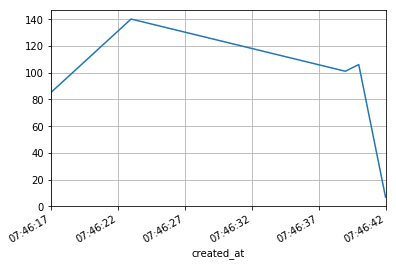

In [30]:
text_lengths.plot(grid=True)
plt.show()